# U-Net segmentation example
### Advanced Deep Learning 2023
This notebook was originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated Stefan Sommer (mailto:sommer@di.ku.dk) and Jon Sporring (mailto:sporring@di.ku.dk).

We consider the data described in:

Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006


## Installs

On non-colab system, is usually good to make an environment and install necessary tools there. E.g., anaconda->jupyter->terminal create an environment, if you have not already, and activate it:
```
conda create -n adl python=3.9
conda activate adl
```
then install missing packages such as:
```
conda install ipykernel torch matplotlib torchmetrics scikit-image jpeg
conda install -c conda-forge segmentation-models-pytorch ipywidgets
```
and if you want to add it to jupyter's drop-down menu
```
ipython kernel install --user --name=adl
```
Now reload the jupyter-notebook's homepage and make a new or load an existing file. On colab, the tools have to be installed everytime

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torchvision.datasets.utils import download_url

from torch import Tensor

import torchmetrics

import segmentation_models_pytorch as smp

import os
import matplotlib.pyplot as plt
import numpy as np

from pprint import pformat
from skimage.transform import resize
from pathlib import Path
from glob import glob
from matplotlib.pyplot import imread
from collections import defaultdict

import wandb

## Set global device 

In [3]:
# GPU support?
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


## Functions
### Loading data sets

In [4]:
def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

def as_torch_dataset(x_arr, y_arr):
    """
    Takes two numpy arrays of data points and labels (x_arr and y_arr, respectively) and
    returns a torch TensorDataset object.
    
    Returns: torch.utils.data.TensorDataset
    """
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(x_arr), 
        torch.FloatTensor(y_arr)
    )
    return dataset

### Visualization

In [5]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask. Segmentation is thresholded at 0.5
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    im = image.cpu().detach().numpy()
    segm = segmentation.cpu().detach().numpy()
    ax.imshow(im.squeeze(), cmap="gray")
    mask = segm < 0.5
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax

### Evaluating a model on data

In [6]:
def evaluate_model_on_single_image(model, x, device=device):
    """
    Evaluate a model on a single data point on the device.
    
    Returns: model(x)
    """
    with torch.no_grad():
        x = x.to(device)
        return model(x.view(1, *x.shape))

In [7]:
def evaluate_model(model, data_loader, metrics_dict, reduction=True, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.
    On each batch, compute all metric functions stored in dictionary 'metrics_dict'.
    
    Returns: dict of metric_name: (list of batch-wise metrics if reduction == False, else single scalar)
    """
    
    # defaultdict(list) returns a dictionary-like object with default_factory list. 
    # When a new key is encountered, an entry is automatically created of type default_factory. 
    metrics = defaultdict(list)
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(data_loader):
            # Predict on batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)
            
            # Compute all metrics
            for metric_name, metric_func in metrics_dict.items():
                value = metric_func(logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                metrics[metric_name].append(value)
    
    if reduction == True:
        # Return mean values
        return {key: np.mean(value) for key, value in metrics.items()}
    else:
        return metrics


### Saving and loading model and optimizer state

In [8]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])

### Plotting training/validation histories

In [9]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    
    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)
    
    return fig, ax

### Main training loop

We want to track the F1 score during training. This generates some additional code. 

In [10]:
def run_one_epoch(model, loss, optimizer, train_loader, val_loader, n_epochs, metrics_dict, device=device):
    """
    Run 1 epoch of training
    Changes to model parameters and optimizer occour internally (state updates)
    Returns:
        two dictionaries, training and a validation metrics
    """
    train_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Zero out stored gradients for all parameters
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        
        print(f"   -- Batch {i+1}/{len(train_loader)}", end=" / ")
        # Predict on batch
        logits = model(batch_x)
        
        # Compute loss function
        loss_tensor = loss(logits, batch_y)
        loss_scalar = loss_tensor.detach().cpu().numpy()
        train_losses.append(loss_scalar)
        print("Loss: ", loss_scalar)
        
        # Backprop and step
        loss_tensor.backward()
        optimizer.step()
        
    # Run validation
    print("   Validation running...")
    val_metrics = evaluate_model(
        model=model, 
        data_loader=val_loader,
        metrics_dict=metrics_dict
    )
    # Return loss and metrics as dicts
    return {"loss": np.mean(train_losses)}, val_metrics


def merge_list_of_dicts(list_of_dicts):
    """
    Takes a list of dictionaries and merges them into a single dictionary pointing to lists
    
    E.g. [{"loss": 5}, {"loss": 3}, {"loss": -2, "F1": 0.5}] --> {"loss": [5, 3, -2], "F1": [0.5]}
    
    Returns: dict
    """
    merged = defaultdict(list)
    for dict_ in list_of_dicts:
        for value, key in dict_.items():
            merged[value].append(key)
    return merged


def training_loop(model, loss, optimizer, train_loader, val_loader, n_epochs, init_epoch=None, metrics_dict=None, save_path=None):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    Supports computing additional metrics on the validation set (only) via the metrics_dict param.
    Specify save_path to store the model at each epoch.
    
    Returns: 
        Two lists of metric dictionaries for each epoch for training and validation, specifically
    """
    train_history, val_history = [], []
    
    metrics_with_loss = {"loss": loss}
    if metrics_dict is not None:
        metrics_with_loss.update(metrics_dict)
    
    if init_epoch == None:
        init_epoch = 0
    try:
        for i in range(init_epoch, n_epochs):
            print(f"Epoch {i+1}/{n_epochs}")
            train_metrics, val_metrics = run_one_epoch(
                model=model, 
                loss=loss, 
                optimizer=optimizer, 
                train_loader=train_loader, 
                val_loader=val_loader, 
                n_epochs=n_epochs,
                metrics_dict=metrics_with_loss
            )
            print("   Mean epoch metrics:")
            print(f"   Training:   {pformat(train_metrics)}")
            print(f"   Validation: {pformat(val_metrics)}")
            wandb.log({"epoch": i+1 ,"train_loss": train_metrics["loss"], 
                       "val_loss": val_metrics["loss"], "val_f1": val_metrics["f1"] }) # modify this line to log more metrics
            train_history.append(train_metrics), val_history.append(val_metrics)
            
            if save_path:
                save_path_epoch = f"epoch_{i+1}_{save_path}"
                print(f"   Saving to: {save_path_epoch}")
                save_model(model, save_path_epoch, optimizer)
                old_path_epoch = f"epoch_{i}_{save_path}"
                if os.path.exists(old_path_epoch):
                    os.remove(old_path_epoch)
                
    except KeyboardInterrupt:
        print("Training stopped.")
        pass
    
    # Merge list of training and validation dicts into single dicts    
    return merge_list_of_dicts(train_history), merge_list_of_dicts(val_history)


## Main program
### Mount Google drive when using Google Colab

In [11]:
# If you are working from Colab, better mount your google drive and change directory appropriately.
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/Colab Notebooks/ADL/assignment1')
except:
    print('Google drive not mounted')
print(os.listdir())

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Google drive not mounted
['.config', 'gdrive', 'epoch_100_model_sweep.ckpt', 'wandb', 'datasets', 'sample_data']


### Setup database

Load database with chest X-rays with lung segmentations.

Using existing ./datasets/lung_field_dataset.npz
x train: (112, 1, 256, 256)
y train: (112, 1, 256, 256)
x val:  (12, 1, 256, 256)
y val:  (12, 1, 256, 256)
x test: (123, 1, 256, 256)
y test: (123, 1, 256, 256)


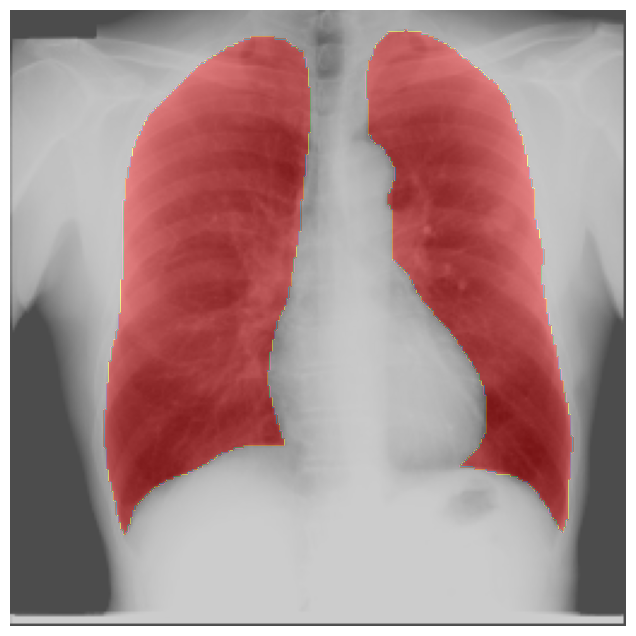

In [12]:
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
  download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
  print('Using existing', data_fn)

# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)
# Bring images into PyTorch format
x_train = np.moveaxis(x_train, 3, 1)
y_train = np.moveaxis(y_train, 3, 1)
x_val = np.moveaxis(x_val, 3, 1)
y_val = np.moveaxis(y_val, 3, 1)
x_test = np.moveaxis(x_test, 3, 1)
y_test = np.moveaxis(y_test, 3, 1)

print("x train:", x_train.shape)
print("y train:", y_train.shape)
print("x val: ", x_val.shape)
print("y val: ", y_val.shape)
print("x test:", x_test.shape)
print("y test:", y_test.shape)

# Init torch datasets
train_dataset = as_torch_dataset(x_train, y_train)
val_dataset = as_torch_dataset(x_val, y_val)
test_dataset = as_torch_dataset(x_test, y_test)

# Init dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Plot an example
fig, ax = plot_image_with_segmentation(*train_dataset[0])
plt.show()

### Init model and optimizer

In [ ]:
# Initialize the wandb
wandb.init(project='U-net')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: huanghaoran22. Use `wandb login --relogin` to force relogin


In [ ]:
# Init U-Net model
model = smp.Unet(encoder_name='efficientnet-b0',in_channels=1,classes=1)

model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

### Continue training?

In [ ]:
# Specify integer, starting at 1
init_epoch = None
if init_epoch != None:
    load_model(model, f"epoch_{init_epoch}_model.ckpt", optimizer)

### Run training

In [ ]:
# Define loss and metrics
loss = torch.nn.MSELoss(reduction="mean")
metrics = {"f1": torchmetrics.classification.F1Score(task='binary', num_classes=1, average="macro", mdmc_average="samplewise")}

# Run training
train_history, val_history = training_loop(
    model=model,
    loss=loss, 
    optimizer=optimizer, 
    train_loader=train_loader, 
    val_loader=val_loader,
    init_epoch=init_epoch,
    n_epochs=100,
    metrics_dict=metrics,
    save_path="model.ckpt"
)

Epoch 1/100
   -- Batch 1/7 / Loss:  1.7217951
   -- Batch 2/7 / Loss:  1.5829227
   -- Batch 3/7 / Loss:  1.4844398
   -- Batch 4/7 / Loss:  1.2963116
   -- Batch 5/7 / Loss:  1.2753147
   -- Batch 6/7 / Loss:  1.1834524
   -- Batch 7/7 / Loss:  1.1137307
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 1.3797095}
   Validation: {'f1': 0.5296065211296082, 'loss': 1.0735965967178345}
   Saving to: epoch_1_model.ckpt
Epoch 2/100
   -- Batch 1/7 / Loss:  1.0446172
   -- Batch 2/7 / Loss:  0.9822502
   -- Batch 3/7 / Loss:  0.9552566
   -- Batch 4/7 / Loss:  0.8770821
   -- Batch 5/7 / Loss:  0.91256464
   -- Batch 6/7 / Loss:  0.85598636
   -- Batch 7/7 / Loss:  0.83108675
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.92269194}
   Validation: {'f1': 0.664101779460907, 'loss': 0.7911665439605713}
   Saving to: epoch_2_model.ckpt
Epoch 3/100
   -- Batch 1/7 / Loss:  0.78724086
   -- Batch 2/7 / Loss:  0.71177375
   -- Batch 3/7 / Loss:  0.

### Plot training and validation histories

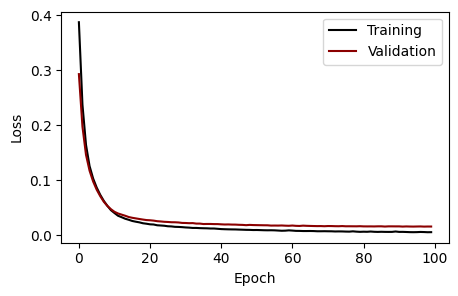

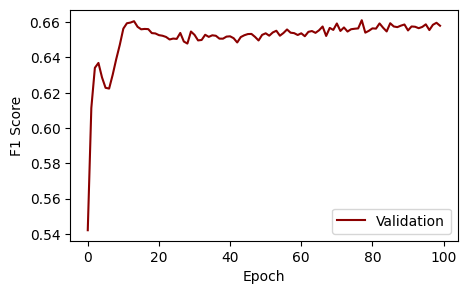

In [ ]:
plot_histories(train_history['loss'], val_history['loss'], label="Loss")
plot_histories(train_history=None, val_history=val_history['f1'], label="F1 Score")
plt.show()

### Evaluate on single test-set image

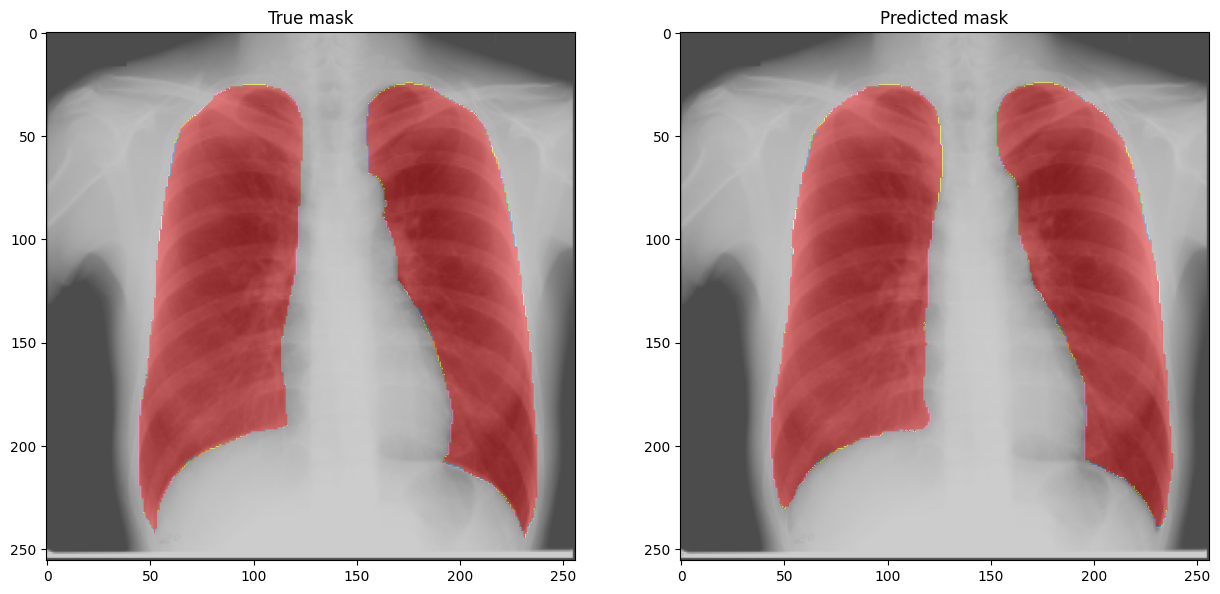

In [ ]:
# Select a test image
x,y = test_dataset[0]
pred = evaluate_model_on_single_image(model, x)

# Plot the result
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
ax1.set_title("True mask")
ax2.set_title("Predicted mask")
plot_image_with_segmentation(x, y, ax=ax1)
plot_image_with_segmentation(x, pred, ax=ax2)
plt.show()

### Evaluate on whole test-set

In [ ]:
# OBS: Returns batch-wise metrics, but test_loader has batch_size = 1
f1_test_scores = evaluate_model(model, test_loader, metrics, reduction=False)["f1"]

print("Test cases:", len(f1_test_scores))
print("Mean F1:   ", np.mean(f1_test_scores))
print("STD  F1:   ", np.std(f1_test_scores))
print("Min. F1:   ", np.min(f1_test_scores))

Test cases: 123
Mean F1:    0.6561593587805585
STD  F1:    0.1717436630398919
Min. F1:    0.3250717520713806


In [ ]:
sum(p.numel() for p in model.parameters())

6250893

# Sweep

In [13]:
sweep_config = {
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [50, 100, 150]},
        "batch_size": {"values": [8, 16, 32, 64]},
        "learning_rate": {"distribution": "uniform", "min": 0.00001, "max": 0.1},
        "optimizer": {"values": ["adam", "sgd"]},
    }
}

sweep_id = wandb.sweep(sweep_config, project="U-net")

Create sweep with ID: tunzdvpw
Sweep URL: https://wandb.ai/huanghaoran22/U-net/sweeps/tunzdvpw


In [14]:
def train(config=None):

    with wandb.init(project='U-net', config=config):
        config = wandb.config
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

        # Init U-Net model
        model = smp.Unet(encoder_name='efficientnet-b0',in_channels=1,classes=1)
        model.to(device)
        # Define loss and metrics
        loss = torch.nn.MSELoss(reduction="mean")
        metrics = {"f1": torchmetrics.classification.F1Score(task='binary', num_classes=1, average="macro", mdmc_average="samplewise")}
        # Define optimizer
        if config.optimizer == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        
        wandb.watch(model, loss, log="all")

        # Run training
        train_history, val_history = training_loop(
            model=model,
            loss=loss,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=config.epochs,
            metrics_dict=metrics,
            save_path="model_sweep.ckpt"
        )

In [15]:
# run sweep
wandb.agent(sweep_id, function=train, count=16)

wandb: Agent Starting Run: 8yjyvu8k with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005469837800534645
wandb: 	optimizer: sgd
wandb: Currently logged in as: huanghaoran22. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
   -- Batch 1/2 / Loss:  1.1585467
   -- Batch 2/2 / Loss:  0.6633154
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.91093105}
   Validation: {'f1': 0.46909937262535095, 'loss': 0.576636016368866}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/50
   -- Batch 1/2 / Loss:  0.5609486
   -- Batch 2/2 / Loss:  0.49787554
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.5294121}
   Validation: {'f1': 0.5633075833320618, 'loss': 0.4048686921596527}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/50
   -- Batch 1/2 / Loss:  0.39208812
   -- Batch 2/2 / Loss:  0.32762462
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.35985637}
   Validation: {'f1': 0.6118377447128296, 'loss': 0.299819678068161}
   Saving to: epoch_3_model_sweep.ckpt
Epoch 4/50
   -- Batch 1/2 / Loss:  0.29610163
   -- Batch 2/2 / Loss:  0.27833828
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.28721994}
   Validat

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▅█▆█▅▃▃▇▅▅▆▅▄▅▇▇▆▆▆▆▅▆▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█
val_loss,█▆▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.04522
val_f1,0.61581
val_loss,0.04677


wandb: Agent Starting Run: 4rnnj6mx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.06649775407429481
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
   -- Batch 1/2 / Loss:  0.9268864
   -- Batch 2/2 / Loss:  21.580109
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 11.253497}
   Validation: {'f1': 0.48469310998916626, 'loss': 0.9774253368377686}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/100
   -- Batch 1/2 / Loss:  1.0029864
   -- Batch 2/2 / Loss:  0.8919479
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.9474672}
   Validation: {'f1': 0.0, 'loss': 2.368440628051758}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/100
   -- Batch 1/2 / Loss:  2.3308272
   -- Batch 2/2 / Loss:  2.2939174
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 2.3123722}
   Validation: {'f1': 0.0, 'loss': 1.6411863565444946}
   Saving to: epoch_3_model_sweep.ckpt
Epoch 4/100
   -- Batch 1/2 / Loss:  1.6634495
   -- Batch 2/2 / Loss:  0.6754047
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 1.1694272}
   Validation: {'f1': 0.49791258573532104, 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▅▁▅▅▇▇▇▇▅▇▅▅▅▅▅▆▇▇▇▇███▅▅▅▅▅████████████
val_loss,▅█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01174
val_f1,0.91415
val_loss,0.01692


wandb: Agent Starting Run: ayr5wuu2 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 50
wandb: 	learning_rate: 0.022699388301693265
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
   -- Batch 1/14 / Loss:  1.1705827
   -- Batch 2/14 / Loss:  0.40980244
   -- Batch 3/14 / Loss:  0.4311049
   -- Batch 4/14 / Loss:  0.31102428
   -- Batch 5/14 / Loss:  0.20541655
   -- Batch 6/14 / Loss:  0.18638147
   -- Batch 7/14 / Loss:  0.137025
   -- Batch 8/14 / Loss:  0.16024093
   -- Batch 9/14 / Loss:  0.14638475
   -- Batch 10/14 / Loss:  0.12637003
   -- Batch 11/14 / Loss:  0.10649792
   -- Batch 12/14 / Loss:  0.11761373
   -- Batch 13/14 / Loss:  0.08648207
   -- Batch 14/14 / Loss:  0.08857877
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.26310754}
   Validation: {'f1': 0.5312013626098633, 'loss': 0.08692370355129242}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/50
   -- Batch 1/14 / Loss:  0.08820881
   -- Batch 2/14 / Loss:  0.08879278
   -- Batch 3/14 / Loss:  0.080435574
   -- Batch 4/14 / Loss:  0.08447859
   -- Batch 5/14 / Loss:  0.07458894
   -- Batch 6/14 / Loss:  0.068114266
   -- Batch 7/14 / Loss:  0.067714214
   

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▃▄▃▆▃▆▃▅▇█▇▆▅▇▆▆▆▇█▇▆▅▅▄▅▆▅▆▄▇▄▇▆▅█▄▆▆█
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.01044
val_f1,0.73623
val_loss,0.01481


wandb: Agent Starting Run: twthl93o with config:
wandb: 	batch_size: 64
wandb: 	epochs: 150
wandb: 	learning_rate: 0.051434728277662455
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
   -- Batch 1/2 / Loss:  1.3471385
   -- Batch 2/2 / Loss:  4.9473476
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 3.147243}
   Validation: {'f1': 0.559799075126648, 'loss': 0.3580855131149292}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/150
   -- Batch 1/2 / Loss:  0.31264067
   -- Batch 2/2 / Loss:  0.46253526
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.38758796}
   Validation: {'f1': 0.7248468995094299, 'loss': 0.3981846272945404}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/150
   -- Batch 1/2 / Loss:  0.38587248
   -- Batch 2/2 / Loss:  0.35129875
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.36858562}
   Validation: {'f1': 0.0006624889210797846, 'loss': 0.45460405945777893}
   Saving to: epoch_3_model_sweep.ckpt
Epoch 4/150
   -- Batch 1/2 / Loss:  0.4208048
   -- Batch 2/2 / Loss:  0.40269694
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.41175085}
   

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▇▁▅▅▆▆▆▆▆▅▇▅▇▇▇▇▆▆██▇███▇████▇█▇██▇▇█▇▇█
val_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.00783
val_f1,0.85892
val_loss,0.01559


wandb: Agent Starting Run: vy5da7vm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.023954442957187894
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
   -- Batch 1/4 / Loss:  0.824259
   -- Batch 2/4 / Loss:  0.6630455
   -- Batch 3/4 / Loss:  0.30391514
   -- Batch 4/4 / Loss:  0.21293007
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.5010374}
   Validation: {'f1': 0.5901037454605103, 'loss': 0.19775444269180298}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/100
   -- Batch 1/4 / Loss:  0.20302871
   -- Batch 2/4 / Loss:  0.17048031
   -- Batch 3/4 / Loss:  0.15585801
   -- Batch 4/4 / Loss:  0.13900553
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.16709314}
   Validation: {'f1': 0.5290898680686951, 'loss': 0.12779492139816284}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/100
   -- Batch 1/4 / Loss:  0.12533277
   -- Batch 2/4 / Loss:  0.11890299
   -- Batch 3/4 / Loss:  0.11855212
   -- Batch 4/4 / Loss:  0.11375943
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.119136825}
   Validation: {'f1': 0.5195427536964417, 'loss': 0.11556816101

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▃▁▁▂▂▂▃▂▂▆▆▂▃▄▂▃▇▅▂▃▄▂▂▂▄▄█▂▂▂▁▆▆▆▇▆▇▁▃▂
val_loss,█▅▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01324
val_f1,0.56986
val_loss,0.01734


wandb: Agent Starting Run: z3zu0p1j with config:
wandb: 	batch_size: 16
wandb: 	epochs: 150
wandb: 	learning_rate: 0.0007238952150095796
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
   -- Batch 1/7 / Loss:  0.5622948
   -- Batch 2/7 / Loss:  0.32243153
   -- Batch 3/7 / Loss:  0.22610205
   -- Batch 4/7 / Loss:  0.17123927
   -- Batch 5/7 / Loss:  0.12823561
   -- Batch 6/7 / Loss:  0.11330452
   -- Batch 7/7 / Loss:  0.0950413
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.23123558}
   Validation: {'f1': 0.5691843032836914, 'loss': 0.08857503533363342}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/150
   -- Batch 1/7 / Loss:  0.08651091
   -- Batch 2/7 / Loss:  0.07445692
   -- Batch 3/7 / Loss:  0.066523954
   -- Batch 4/7 / Loss:  0.063595936
   -- Batch 5/7 / Loss:  0.05980582
   -- Batch 6/7 / Loss:  0.052671097
   -- Batch 7/7 / Loss:  0.05117052
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.06496216}
   Validation: {'f1': 0.5588340759277344, 'loss': 0.04728315398097038}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/150
   -- Batch 1/7 / Loss:  0.04347589
   -- Batch 2/7 / Loss:  0.04339527

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▅▃▂▆▄▆▃▂▄▃▆▃▅▇▆▃▅▃▆▆▃▃▃▄▂▅▆▂▃▇▅▇▂▅█▃▇▅▅
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.00216
val_f1,0.69075
val_loss,0.01311


wandb: Agent Starting Run: y9cd6xqj with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0680456266903415
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
   -- Batch 1/7 / Loss:  1.9137897
   -- Batch 2/7 / Loss:  15.120544
   -- Batch 3/7 / Loss:  4.2125206
   -- Batch 4/7 / Loss:  0.198244
   -- Batch 5/7 / Loss:  1.1725526
   -- Batch 6/7 / Loss:  1.7836049
   -- Batch 7/7 / Loss:  1.421452
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 3.6889584}
   Validation: {'f1': 0.4849940836429596, 'loss': 1.3127164840698242}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/50
   -- Batch 1/7 / Loss:  1.3153526
   -- Batch 2/7 / Loss:  1.0702752
   -- Batch 3/7 / Loss:  0.7636118
   -- Batch 4/7 / Loss:  0.56036866
   -- Batch 5/7 / Loss:  0.40544853
   -- Batch 6/7 / Loss:  0.3209353
   -- Batch 7/7 / Loss:  0.26025286
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.6708921}
   Validation: {'f1': 0.5030301213264465, 'loss': 0.22564469277858734}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/50
   -- Batch 1/7 / Loss:  0.22621317
   -- Batch 2/7 / Loss:  0.18343708
   -- Batch 3/7 / L

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁█▁█▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.01283
val_f1,0.48505
val_loss,0.01857


wandb: Agent Starting Run: 1bv6hlvu with config:
wandb: 	batch_size: 8
wandb: 	epochs: 150
wandb: 	learning_rate: 0.05821133074241261
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
   -- Batch 1/14 / Loss:  1.2305851
   -- Batch 2/14 / Loss:  2.240968
   -- Batch 3/14 / Loss:  1.2336241
   -- Batch 4/14 / Loss:  0.4677019
   -- Batch 5/14 / Loss:  0.52919996
   -- Batch 6/14 / Loss:  0.5564735
   -- Batch 7/14 / Loss:  0.23556766
   -- Batch 8/14 / Loss:  0.2605816
   -- Batch 9/14 / Loss:  0.14984342
   -- Batch 10/14 / Loss:  0.17337601
   -- Batch 11/14 / Loss:  0.17456016
   -- Batch 12/14 / Loss:  0.11160686
   -- Batch 13/14 / Loss:  0.16007577
   -- Batch 14/14 / Loss:  0.11738639
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.54582506}
   Validation: {'f1': 0.4951270818710327, 'loss': 0.10581289976835251}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/150
   -- Batch 1/14 / Loss:  0.10113887
   -- Batch 2/14 / Loss:  0.09317324
   -- Batch 3/14 / Loss:  0.091761805
   -- Batch 4/14 / Loss:  0.093155995
   -- Batch 5/14 / Loss:  0.08429733
   -- Batch 6/14 / Loss:  0.09927362
   -- Batch 7/14 / Loss:  0.086232215
   -

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▂▆▁▂▂▆▆▇▂██▇▂▆▂▆▁▂█▇▇▁█▇▁▇▁█▂▂█▁▂█▇█▁▂
val_loss,█▅▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.00532
val_f1,0.53561
val_loss,0.01323


wandb: Agent Starting Run: ae3jnm71 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01871767757375514
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
   -- Batch 1/14 / Loss:  1.003998
   -- Batch 2/14 / Loss:  0.46793595
   -- Batch 3/14 / Loss:  0.28140163
   -- Batch 4/14 / Loss:  0.24628259
   -- Batch 5/14 / Loss:  0.21175979
   -- Batch 6/14 / Loss:  0.1511342
   -- Batch 7/14 / Loss:  0.14891727
   -- Batch 8/14 / Loss:  0.09892997
   -- Batch 9/14 / Loss:  0.087969884
   -- Batch 10/14 / Loss:  0.119394995
   -- Batch 11/14 / Loss:  0.12648156
   -- Batch 12/14 / Loss:  0.08134012
   -- Batch 13/14 / Loss:  0.07045173
   -- Batch 14/14 / Loss:  0.07984485
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.22684589}
   Validation: {'f1': 0.5115997791290283, 'loss': 0.07166887819766998}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/50
   -- Batch 1/14 / Loss:  0.081524506
   -- Batch 2/14 / Loss:  0.056431264
   -- Batch 3/14 / Loss:  0.06203302
   -- Batch 4/14 / Loss:  0.045169376
   -- Batch 5/14 / Loss:  0.04425005
   -- Batch 6/14 / Loss:  0.04091582
   -- Batch 7/14 / Loss:  0.03710585


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▆▆▃▄▂▆▂▂▂▂▁▅▂▁▃▄█▆█▅▇▁▆▆▆▅▂▂▂█▄▂▁▄▂▂█▂▇
val_loss,█▄▂▂▂▂▁▂▁▁▂▁▁▁▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,50
train_loss,0.00647
val_f1,0.8763
val_loss,0.01497


wandb: Agent Starting Run: yr8bbw23 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 150
wandb: 	learning_rate: 0.013232041859624536
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
   -- Batch 1/4 / Loss:  0.79245675
   -- Batch 2/4 / Loss:  0.6902344
   -- Batch 3/4 / Loss:  0.87409586
   -- Batch 4/4 / Loss:  0.13568899
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.623119}
   Validation: {'f1': 0.715301513671875, 'loss': 0.1607697755098343}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/150
   -- Batch 1/4 / Loss:  0.16788715
   -- Batch 2/4 / Loss:  0.1461373
   -- Batch 3/4 / Loss:  0.114298455
   -- Batch 4/4 / Loss:  0.079461925
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.12694621}
   Validation: {'f1': 0.5041645765304565, 'loss': 0.07574271410703659}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/150
   -- Batch 1/4 / Loss:  0.074262366
   -- Batch 2/4 / Loss:  0.0812719
   -- Batch 3/4 / Loss:  0.07451707
   -- Batch 4/4 / Loss:  0.060179316
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.072557665}
   Validation: {'f1': 0.5326473116874695, 'loss': 0.0430416762

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▆▂▆▇▂▁▁█▇▂▃▁▂▅▇▂▃▄▃▁▇▇▂▆▆▁▆▇▁▇▆▂▃▂▇▄▇▁▆
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.00388
val_f1,0.75226
val_loss,0.01422


wandb: Agent Starting Run: pp4a6p59 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 150
wandb: 	learning_rate: 0.020757626634973263
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
   -- Batch 1/7 / Loss:  1.3782477
   -- Batch 2/7 / Loss:  1.0743243
   -- Batch 3/7 / Loss:  0.9156495
   -- Batch 4/7 / Loss:  0.2894347
   -- Batch 5/7 / Loss:  0.13659689
   -- Batch 6/7 / Loss:  0.2032182
   -- Batch 7/7 / Loss:  0.23025295
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.6039606}
   Validation: {'f1': 0.7678362727165222, 'loss': 0.20043963193893433}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/150
   -- Batch 1/7 / Loss:  0.19099335
   -- Batch 2/7 / Loss:  0.12985265
   -- Batch 3/7 / Loss:  0.10368076
   -- Batch 4/7 / Loss:  0.10596049
   -- Batch 5/7 / Loss:  0.11136229
   -- Batch 6/7 / Loss:  0.08776146
   -- Batch 7/7 / Loss:  0.082751274
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.116051756}
   Validation: {'f1': 0.5083750486373901, 'loss': 0.08710914850234985}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/150
   -- Batch 1/7 / Loss:  0.08847382
   -- Batch 2/7 / Loss:  0.066242084
   

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▂▄▃▅▃▅▂▆▆▃▆▆█▂▆▇▆▅▆▄▅▂▃▇▃▄▃▂▆▆▇▄▂▆▂▄▆▆
val_loss,█▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.00312
val_f1,0.8195
val_loss,0.01449


wandb: Agent Starting Run: kw6nzdcj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 150
wandb: 	learning_rate: 0.09306682475244182
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
   -- Batch 1/2 / Loss:  1.8329164
   -- Batch 2/2 / Loss:  23.261261
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 12.547089}
   Validation: {'f1': 0.4849992096424103, 'loss': 4.631310939788818}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/150
   -- Batch 1/2 / Loss:  4.602313
   -- Batch 2/2 / Loss:  0.3205484
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 2.4614308}
   Validation: {'f1': 0.0, 'loss': 0.5329198241233826}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/150
   -- Batch 1/2 / Loss:  0.49521393
   -- Batch 2/2 / Loss:  0.69109005
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.593152}
   Validation: {'f1': 0.0, 'loss': 0.8573194146156311}
   Saving to: epoch_3_model_sweep.ckpt
Epoch 4/150
   -- Batch 1/2 / Loss:  0.84505093
   -- Batch 2/2 / Loss:  0.9765507
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.9108008}
   Validation: {'f1': 0.0, 'loss': 1.005302

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.2113
val_f1,0.0
val_loss,0.21791


wandb: Agent Starting Run: 1so2qfqp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.016125167842028033
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
   -- Batch 1/4 / Loss:  1.522157
   -- Batch 2/4 / Loss:  0.5241845
   -- Batch 3/4 / Loss:  0.29815108
   -- Batch 4/4 / Loss:  0.31032044
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.6637032}
   Validation: {'f1': 0.6202079653739929, 'loss': 0.23208045959472656}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/50
   -- Batch 1/4 / Loss:  0.23578453
   -- Batch 2/4 / Loss:  0.18403211
   -- Batch 3/4 / Loss:  0.19368947
   -- Batch 4/4 / Loss:  0.15909833
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.1931511}
   Validation: {'f1': 0.5011630058288574, 'loss': 0.1657019704580307}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/50
   -- Batch 1/4 / Loss:  0.16346915
   -- Batch 2/4 / Loss:  0.125217
   -- Batch 3/4 / Loss:  0.11990479
   -- Batch 4/4 / Loss:  0.13254169
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.13528316}
   Validation: {'f1': 0.6017009615898132, 'loss': 0.10929393768310547}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▅▁▅▃▆▄▂▂▅▃▃▃▄▂▆▅▅▅▅▆▅▅▇▄▃▅▇▆▄▆▅█▄▇▇▅▅▇▆▇
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.02231
val_f1,0.67202
val_loss,0.02367


wandb: Agent Starting Run: sz6sv686 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.031279367274559114
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
   -- Batch 1/4 / Loss:  0.79929507
   -- Batch 2/4 / Loss:  0.44980752
   -- Batch 3/4 / Loss:  0.34080002
   -- Batch 4/4 / Loss:  0.2880543
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.46948922}
   Validation: {'f1': 0.5075397491455078, 'loss': 0.24796567857265472}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/100
   -- Batch 1/4 / Loss:  0.24844997
   -- Batch 2/4 / Loss:  0.17663077
   -- Batch 3/4 / Loss:  0.19664381
   -- Batch 4/4 / Loss:  0.11982219
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.18538669}
   Validation: {'f1': 0.48909124732017517, 'loss': 0.1644410490989685}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/100
   -- Batch 1/4 / Loss:  0.17309363
   -- Batch 2/4 / Loss:  0.10881536
   -- Batch 3/4 / Loss:  0.11874991
   -- Batch 4/4 / Loss:  0.0992748
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.12498343}
   Validation: {'f1': 0.5526296496391296, 'loss': 0.1040891408

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▂▁▂▂▃▄▄▅▃▅▃▂▃█▃▆▁▁▂▇▇▅▂▄▅▅▅▄▇▆▅▂▄█▇▄█▅▆
val_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01201
val_f1,0.75037
val_loss,0.01605


wandb: Agent Starting Run: fphvtykk with config:
wandb: 	batch_size: 8
wandb: 	epochs: 100
wandb: 	learning_rate: 0.02734565537515488
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
   -- Batch 1/14 / Loss:  1.3164918
   -- Batch 2/14 / Loss:  0.48887104
   -- Batch 3/14 / Loss:  0.6934807
   -- Batch 4/14 / Loss:  0.38780475
   -- Batch 5/14 / Loss:  0.2881868
   -- Batch 6/14 / Loss:  0.34286842
   -- Batch 7/14 / Loss:  0.18042289
   -- Batch 8/14 / Loss:  0.14271387
   -- Batch 9/14 / Loss:  0.31501493
   -- Batch 10/14 / Loss:  0.14304608
   -- Batch 11/14 / Loss:  0.10839923
   -- Batch 12/14 / Loss:  0.16910687
   -- Batch 13/14 / Loss:  0.17068374
   -- Batch 14/14 / Loss:  0.12229292
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.34781316}
   Validation: {'f1': 0.5072636157274246, 'loss': 0.10340603813529015}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/100
   -- Batch 1/14 / Loss:  0.111071296
   -- Batch 2/14 / Loss:  0.12512314
   -- Batch 3/14 / Loss:  0.11139137
   -- Batch 4/14 / Loss:  0.08731881
   -- Batch 5/14 / Loss:  0.08661145
   -- Batch 6/14 / Loss:  0.096787296
   -- Batch 7/14 / Loss:  0.08746877
 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▂▃▆▃▅▃▂▄▄▇▆▆▄█▇▅▆▆▄▇▆▄▄▃▇▄▃▂▅▅▄▄▇▆▃█▆▄
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.00761
val_f1,0.6199
val_loss,0.01365


wandb: Agent Starting Run: yoq8du9c with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	learning_rate: 0.06188411384545224
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
   -- Batch 1/7 / Loss:  2.4281483
   -- Batch 2/7 / Loss:  13.46666
   -- Batch 3/7 / Loss:  6.7634363
   -- Batch 4/7 / Loss:  0.3426462
   -- Batch 5/7 / Loss:  2.1487937
   -- Batch 6/7 / Loss:  4.8012233
   -- Batch 7/7 / Loss:  0.20546253
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 4.308053}
   Validation: {'f1': 0.5306811928749084, 'loss': 0.18323929607868195}
   Saving to: epoch_1_model_sweep.ckpt
Epoch 2/50
   -- Batch 1/7 / Loss:  0.18618184
   -- Batch 2/7 / Loss:  0.1854499
   -- Batch 3/7 / Loss:  0.33789295
   -- Batch 4/7 / Loss:  0.21966663
   -- Batch 5/7 / Loss:  0.22732338
   -- Batch 6/7 / Loss:  0.23718151
   -- Batch 7/7 / Loss:  0.2370516
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.232964}
   Validation: {'f1': 0.5195965766906738, 'loss': 0.23163406550884247}
   Saving to: epoch_2_model_sweep.ckpt
Epoch 3/50
   -- Batch 1/7 / Loss:  0.2319789
   -- Batch 2/7 / Loss:  0.22437027
   -- Batch 3/7 /

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▂▁▁▁▁▁▂▃▂▂▂▂▃▃▂▃▂▃▄▂▃▄▂▇▅▄▄▄▄▅▂▅█▂▇▂▅▅▆▅
val_loss,▆██▇▇▆▆▆▅▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.02282
val_f1,0.65044
val_loss,0.02453
